## Importing the required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Importing the Player Informations Dataset

In [3]:
df = pd.read_csv('Player_Data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sl.no            633 non-null    int64  
 1   Player           633 non-null    object 
 2   Base Price       633 non-null    object 
 3   Type             633 non-null    object 
 4   Cost in Cr       237 non-null    float64
 5   Cost in Dollars  237 non-null    float64
 6   Team2021         199 non-null    object 
 7   Team2022         633 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 39.7+ KB


In [5]:
df.shape

(633, 8)

## Column Processing :

In [7]:
# Dropping the df['Sl.no', 'Cost in Dollars'] column
df.drop(['Sl.no', 'Cost in Dollars'], axis=1, inplace=True)

In [8]:
# Checking Null Values
df.isnull().sum()

Player          0
Base Price      0
Type            0
Cost in Cr    396
Team2021      434
Team2022        0
dtype: int64

In [9]:
# Treating Null Values of 'Team2021' column
df['Team2021'].fillna('Unsold', inplace=True)

In [10]:
# Converting Other team names to 'Sold' level
mask = df['Team2021']!='Unsold'
df.loc[mask , 'Team2021'] = 'Sold'

In [11]:
# Doing the same for 'Team2022'
mask = df['Team2022']!='Unsold'
df.loc[mask , 'Team2022'] = 'Sold'

In [12]:
# Treating the null values in 'Cost in Cr' column
df['Cost in Cr'].fillna(0 , inplace=True)

In [13]:
# Re-checking Null Values
df.isnull().sum()

Player        0
Base Price    0
Type          0
Cost in Cr    0
Team2021      0
Team2022      0
dtype: int64

In [14]:
# Transforming the ['Base Price'] column to continuous column
# Function for column transformation
def base_price_transformer(column):
    column = column.copy()
    
    mask_lakh = column[column.str.split(' ').str[1]=='Lakh'].str.split(' ').str[0].astype(float)
    mask_cr = column[column.str.split(' ').str[1]=='Cr'].str.split(' ').str[0].astype(float)
    
    column[column.str.split(' ').str[1]=='Pick'] = 1800000
    column[column == 'Retained'] = 1600000
    column[column.str.split(' ').str[1]=='Lakh'] = mask_lakh * 100000
    column[column.str.split(' ').str[1]=='Cr'] = mask_cr * 10000000
    
    return column
    
df['Base Price'] = base_price_transformer(df['Base Price'])
df['Base Price']=df['Base Price'].astype(float)

In [15]:
# Transforming the ['Cost in Cr'] to proper value
df['Cost in Cr'] = df['Cost in Cr'] * 10000000

In [16]:
# Creating a new ['Player Tier'] column based on [['Cost in Cr]-['Base Price']]
# Function to determine the player tier
def assign_player_tier(row):
    difference_ratio = (row['Cost in Cr'] - row['Base Price']) / row['Base Price']

    if difference_ratio > 1:
        return 'Tier 1'
    elif 0.75 < difference_ratio <= 1:
        return 'Tier 2'
    elif 0.5 < difference_ratio <= 0.75:
        return 'Tier 3'
    elif 0.25 < difference_ratio <= 0.5:
        return 'Tier 4'
    elif 0 < difference_ratio <= 0.25:
        return 'Tier 5'
    elif difference_ratio <= 0:
        return 'Tier 6'

# Apply the function to create the 'Player Tier' column
df['Player Tier'] = df.apply(assign_player_tier, axis=1)

In [17]:
# Dropping the ['Player'] column
df.drop(['Player'], axis=1, inplace=True)

In [18]:
# Imputing the base price where 'Cost in Cr' is zero
df['Cost in Cr'] = np.where(df['Cost in Cr']==0, df['Base Price'], df['Cost in Cr'])

In [19]:
# Rearranging the columns
df = df.loc[:,['Player Tier', 'Base Price', 'Type', 'Team2021', 'Team2022', 'Cost in Cr']]

## Exploraty Data Analysis :

<Axes: xlabel='Player Tier', ylabel='count'>

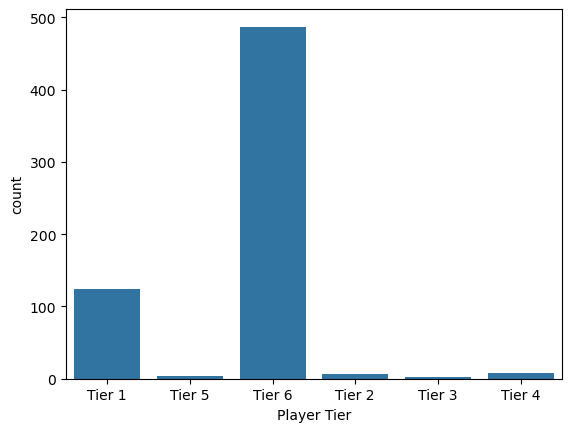

In [20]:
# Distribution of player tiers
sns.countplot(x=df['Player Tier'])

<Axes: xlabel='Type', ylabel='count'>

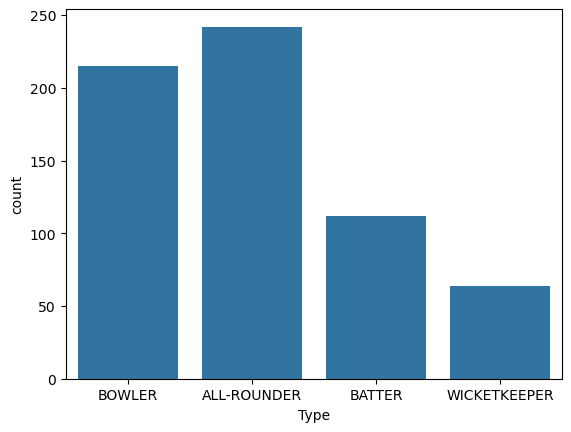

In [21]:
# Distribution of player type
sns.countplot(x=df['Type'])

<Axes: xlabel='Base Price', ylabel='Count'>

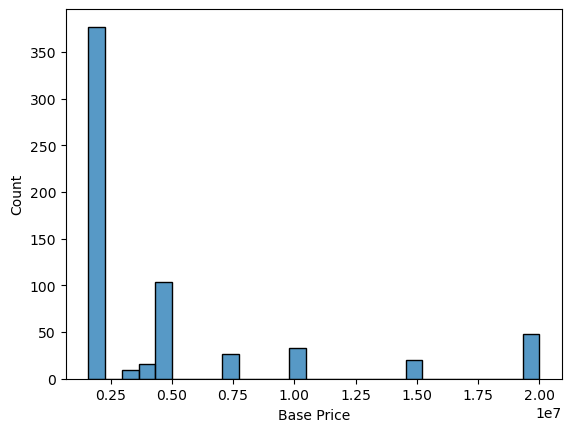

In [22]:
# Distribution of base price
sns.histplot(df['Base Price'])

<Axes: xlabel='Team2021', ylabel='count'>

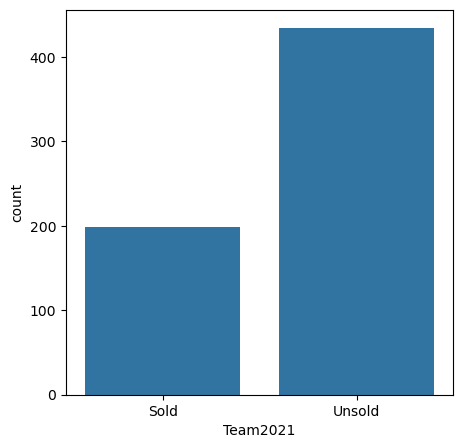

In [24]:
# Distribution of 2021 teams
plt.figure(figsize=(5,5))
sns.countplot(x=df['Team2021'])

<Axes: xlabel='Team2022', ylabel='count'>

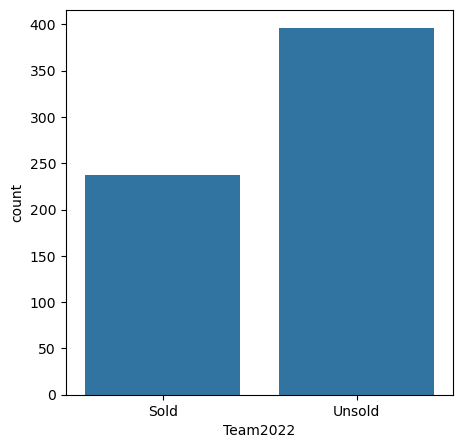

In [25]:
# Ditribution of 2022 teams
plt.figure(figsize=(5,5))
sns.countplot(x=df['Team2022'])

### note : Correlation plot is checked after convertion of categorical variables into dummy variables

## Feature Engineering :

In [26]:
# Independant variable dataframe
X=df.iloc[:,:-1]
# Dependent variable series
y=df.iloc[:,-1].values

In [27]:
# Creating dummy variables for categorical varials excluding 'Player Tier'
X =pd.get_dummies(X, columns = ['Type' , 'Team2021' , 'Team2022'], drop_first=True, dtype=int)

In [28]:
# LabelEcoding 'Player Tier' since the Tiers are ordinal in nature
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X['Player Tier'] = encoder.fit_transform(X['Player Tier'])

<Axes: >

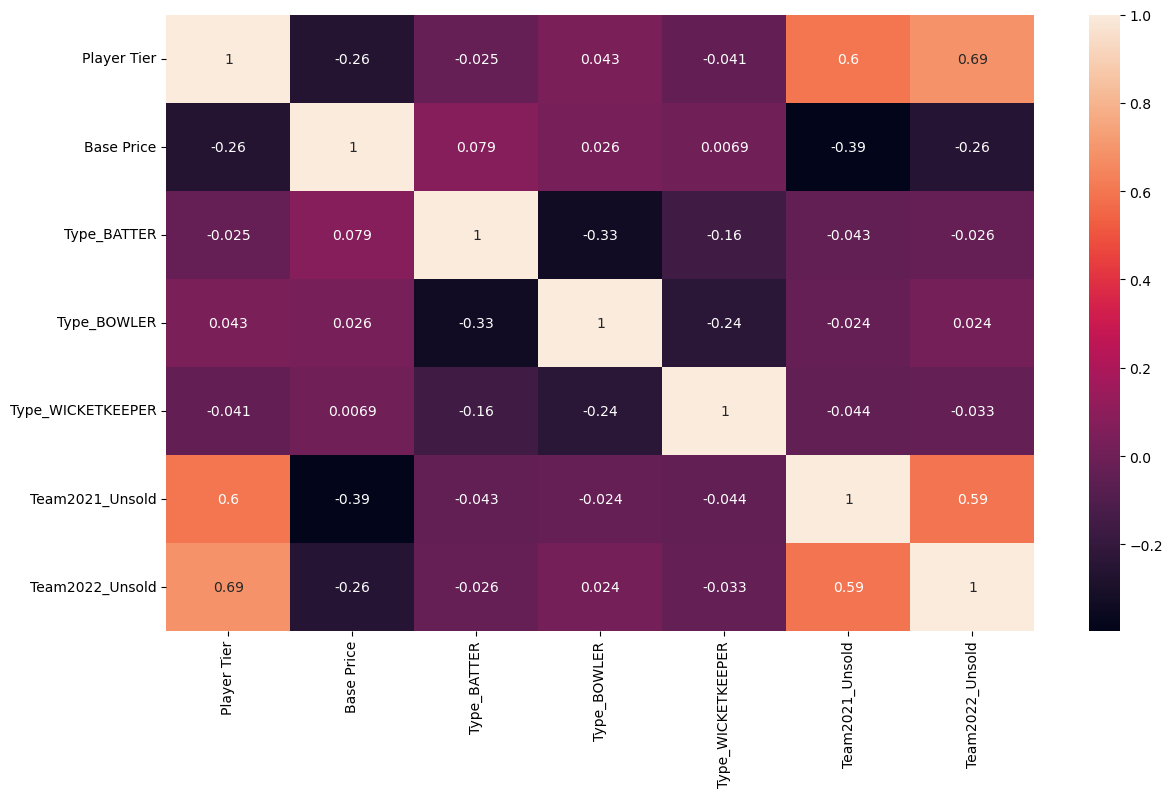

In [29]:
# Checking Corelation between Variables
plt.figure(figsize=(14,8))
sns.heatmap(X.corr(), annot=True)

## Train, Test Data splitting :

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Checking the variance inflation factor for variables for multicolinearity

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(X_train.values, j) for j in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,8.0,Player Tier
1,1.6,Base Price
2,1.4,Type_BATTER
3,1.7,Type_BOWLER
4,1.2,Type_WICKETKEEPER
5,5.1,Team2021_Unsold
6,5.7,Team2022_Unsold


## Feature Scaling :

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Training :

In [33]:
# Random forest regression model
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=300, random_state=1, max_depth=5)
reg.fit(X_train,y_train)

## Predicting :

In [35]:
y_pred = reg.predict(X_test)

## Model Performance Evaluation :

In [44]:
# Result dataframe
result_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
result_df['residual'] = result_df['y_test']-result_df['y_pred']
result_df['AE'] = np.abs(result_df['residual'])
result_df['APE'] = np.abs(result_df['residual']/result_df['y_test']*100)
print(f"Mean absolute error : {result_df['AE'].mean():0.0f}")
print(f"Mean absolute percentage error : {result_df['APE'].mean():0.4f}%")
print(f"Model accuracy for X_test: {100-(np.mean(np.abs((y_test - reg.predict(X_test)) / y_test)) * 100):0.4f}%")
print(f"Model accuracy for X_train: {100-(np.mean(np.abs((y_train - reg.predict(X_train)) / y_train)) * 100):0.4f}%")

Mean absolute error : 4455447
Mean absolute percentage error : 18.7718%
Model accuracy for X_test: 81.2282%
Model accuracy for X_train: 87.4587%


In [45]:
result_df.head()

,y_test,y_pred,residual,AE,APE
0,2000000.0,2.002221e+06,-2221.362530,2221.362530,0.111068
1,2000000.0,2.002221e+06,-2221.362530,2221.362530,0.111068
2,5000000.0,4.942882e+06,57118.431925,57118.431925,1.142369
3,7500000.0,7.559249e+06,-59248.831843,59248.831843,0.789984
4,2000000.0,2.002221e+06,-2221.362530,2221.362530,0.111068
